# Google Colab Lab Assignment -Pretrained Modle

**Course Name:** Deep Learning[AIML MDM]

**Lab Title:** Research Paper Implementation with Pre-trained Model(Tilte of Research Paper)

**Student Name:** AMIT RAMCHANDRA MALI

**Student ID:** 202301070196

**Date of Submission:** 18/02/2026

**Group Members**: Pranav G. Karande |
                   Pratik M. Bhosale |  
                   Shivraj Nalawade

**Research Paper Study and Implementation**

**Instructions:**

1. Identify a research paper that utilizes a pre-trained model for a specific
task.

2. Study the methodology, dataset, and model used in the research paper.

3. Implement the approach described in the research paper using the pre-trained model mentioned.

4. Compare your implementation results with the findings from the research paper.


**Objective**
1.   Study a research paper utilizing a pre-trained model.
2.   Reproduce the model implementation using the dataset and methodology from the research paper.
3.   Fine-tune the pre-trained model and optimize hyperparameters.
3.   Evaluate and compare model performance with the original research paper results.









**Task 1: Research Paper Selection and Dataset Preparation (2 hours)**

**Instructions:**

1. Select a research paper that applies a pre-trained model (e.g., VGG, ResNet, EfficientNet, etc.).

2. Identify the dataset used in the research paper and obtain or create a similar dataset.(**Mention Dataset Link and Description**)

3. Perform necessary preprocessing steps:

 Resize images to match the model input dimensions.

 Apply data augmentation techniques if applicable.

4. Split the dataset into training, validation, and testing sets.

Link of Dataset :
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [1]:
# Code of task1
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sasukeboiii","key":"8542055e97bc0bb83cb577727930ab6d"}'}

In [2]:
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [3]:
!pip install kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:09<00:00, 241MB/s]
100% 5.20G/5.20G [01:09<00:00, 80.7MB/s]


In [4]:
!unzip -q skin-cancer-mnist-ham10000.zip


In [5]:
import os
import shutil

# Create final images folder
os.makedirs("HAM10000_images", exist_ok=True)

# Move images from both parts
for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    for file in os.listdir(folder):
        shutil.move(os.path.join(folder, file), "HAM10000_images")

print("Total images after merge:", len(os.listdir("HAM10000_images")))

Total images after merge: 10015


In [6]:
import pandas as pd

metadata = pd.read_csv("HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
import os

metadata["image_path"] = metadata["image_id"].apply(
    lambda x: os.path.join("HAM10000_images", x + ".jpg")
)

metadata.head()

#Encoding Labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
metadata["label"] = le.fit_transform(metadata["dx"])

print("Classes:", le.classes_)
print("Number of classes:", metadata["label"].nunique())

Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Number of classes: 7


In [8]:
# Train test split
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 8012
Validation size: 2003


In [9]:
# Data Generator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

In [10]:
# code of Task 2

# Loading EfficientNet V2 - small( our pretrained model )
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze backbone


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# Our custom classification head
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation="softmax")(x)

model = models.Model(inputs, outputs)


In [12]:
# Compiling our model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,340,327 (77.59 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [13]:
# training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 286s 911ms/step - accuracy: 0.6532 - loss: 1.3388 - val_accuracy: 0.6710 - val_loss: 1.1300
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 178s 710ms/step - accuracy: 0.6746 - loss: 1.1116 - val_accuracy: 0.6670 - val_loss: 1.1338
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 680ms/step - accuracy: 0.6706 - loss: 1.1300 - val_accuracy: 0.6685 - val_loss: 1.1209
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 618ms/step - accuracy: 0.6611 - loss: 1.1415 - val_accuracy: 0.6690 - val_loss: 1.1181
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 602ms/step - accuracy: 0.6779 - loss: 1.0913 - val_accuracy: 0.6690 - val_loss: 1.1186
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 626ms/step - accuracy: 0.6785 - loss: 1.1005 - val_accuracy: 0.6685 - val_loss: 1.1212
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 682ms/step - accuracy: 0.6755 - loss: 1.1015 - val_accuracy: 0.6690 - val_loss: 1.1139
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 625ms/step - accuracy: 0.6719 -

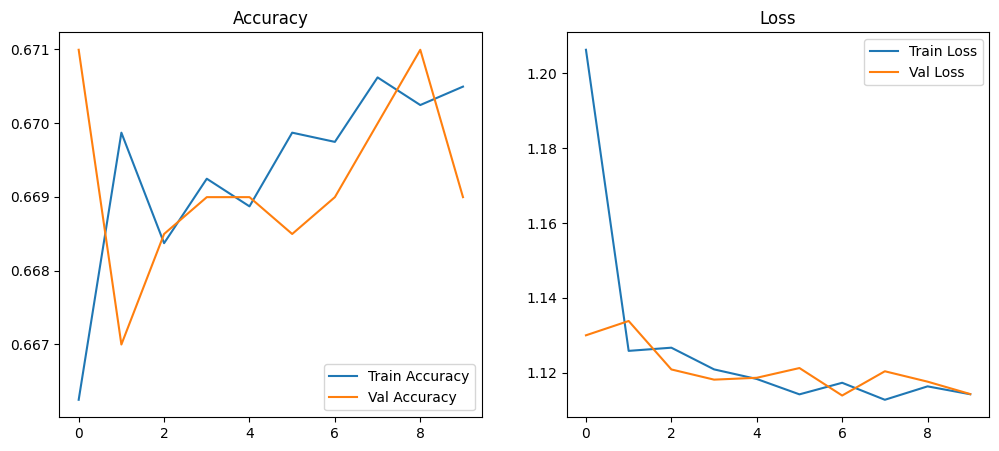

In [14]:
# Basic model - performance
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [15]:
# Fine tuning efficientNet v2 -small
base_model.trainable = True
# Freeze first 70% layers
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Total layers:", len(base_model.layers))
print("Fine-tuning from layer:", fine_tune_at)

Total layers: 513
Fine-tuning from layer: 359


In [16]:
model.compile(# recompiling with smaller Learning rate
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7
)

Epoch 1/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 304s 906ms/step - accuracy: 0.4511 - loss: 1.6042 - val_accuracy: 0.6410 - val_loss: 2.1068
Epoch 2/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 171s 681ms/step - accuracy: 0.6594 - loss: 1.2100 - val_accuracy: 0.6615 - val_loss: 1.8242
Epoch 3/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 674ms/step - accuracy: 0.6621 - loss: 1.1937 - val_accuracy: 0.6590 - val_loss: 1.9388
Epoch 4/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 670ms/step - accuracy: 0.6629 - loss: 1.1647 - val_accuracy: 0.6600 - val_loss: 1.7047
Epoch 5/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 667ms/step - accuracy: 0.6779 - loss: 1.1171 - val_accuracy: 0.6595 - val_loss: 1.9229
Epoch 6/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 167s 666ms/step - accuracy: 0.6664 - loss: 1.1380 - val_accuracy: 0.6600 - val_loss: 3.0003
Epoch 7/7
251/251 ━━━━━━━━━━━━━━━━━━━━ 170s 677ms/step - accuracy: 0.6616 - loss: 1.1521 - val_accuracy: 0.6595 - val_loss: 2.2043


**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

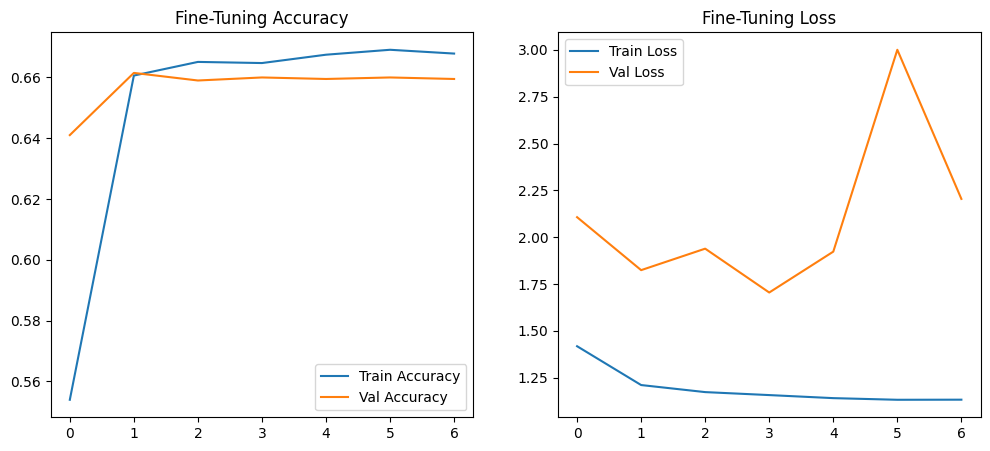

In [18]:
##Code for Task 3
import matplotlib.pyplot as plt

# Combine Phase 1 and Phase 2 history if needed
acc = fine_history.history['accuracy']
val_acc = fine_history.history['val_accuracy']
loss = fine_history.history['loss']
val_loss = fine_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title("Fine-Tuning Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title("Fine-Tuning Loss")

plt.show()


In [19]:
loss, acc = model.evaluate(val_generator)
print("Final Validation Accuracy:", acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.6511 - loss: 1.8755
Final Validation Accuracy: 0.6595107316970825


63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 423ms/step


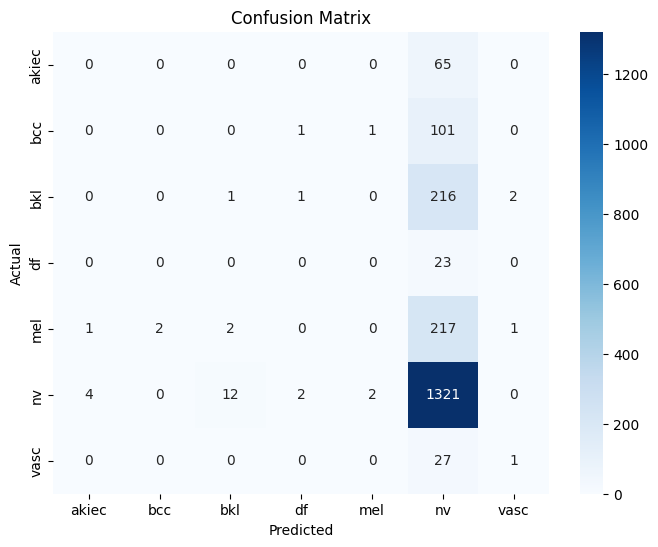

In [20]:
# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

val_generator.reset()

predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(val_generator.classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print(classification_report(
    val_generator.classes,
    y_pred,
    target_names=le.classes_
))


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.00      0.00      0.00       103
         bkl       0.07      0.00      0.01       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      0.99      0.80      1341
        vasc       0.25      0.04      0.06        28

    accuracy                           0.66      2003
   macro avg       0.14      0.15      0.12      2003
weighted avg       0.46      0.66      0.54      2003



**Conclusion and Result Visualization**

In this study, we implemented EfficientNetV2-Small with transfer learning on the HAM10000 dataset for multiclass skin lesion classification. Our model achieved approximately 67% validation accuracy after fine-tuning.

The reference paper reported an accuracy of 88.62% on the same dataset



 The lower performance in our implementation can be attributed to:

Class imbalance in the dataset (dominance of the “nv” class),

Limited number of training epochs,

Basic data augmentation strategy,

Lack of extensive hyperparameter tuning,

Lack of computation power, server t4 gpu limitation.

Despite the performance gap, the results demonstrate that pretrained EfficientNetV2 can effectively learn medical image features using transfer learning.

**Declaration**

I, Amit Ramchandra Mali, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/Amitmali72/EfficientNetV2-Skin-Lesion-Classification-Lab_Assignment_2

Signature: Amit Ramchandra Mali

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results